In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

In [3]:
stack_fixed = 'MD661'
# stack_fixed = 'MD652'
stack_moving = 'atlasV4'
# stack_moving = 'atlasV3'

In [5]:
detector_id = 1
warp_setting = 13

In [6]:
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight
warp_id,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000,2000,2000,30,0,NaN
2,1,rigid,0.000010,100000.0,10000.0,100,100,100,30,0,NaN
4,1,rigid,0.000001,100000.0,10000.0,100,100,100,10,0,0.000001
5,1,rigid,0.000001,100000.0,10000.0,100,100,100,30,inverse,0.000000
6,1,affine,0.000010,100000.0,10000.0,100,100,100,30,-0.5,0.000000
7,None,rigid,0.000001,100000.0,1000.0,50,50,50,10,0,NaN
8,1,rigid,0.000001,100000.0,10000.0,200,200,200,30,inverse,0.000000
9,13,rigid,0.000001,100000.0,10000.0,200,200,200,30,inverse,0.000000
10,None,rigid,0.000010,100000.0,1000.0,100,100,100,30,0,NaN


In [7]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    include_surround = True

upstream_warp_id                    None
transform_type                    affine
terminate_thresh                   1e-05
grad_computation_sample_number    100000
grid_search_sample_number           1000
std_tx_um                           2000
std_ty_um                           2000
std_tz_um                           2000
std_theta_xy_degree                   30
surround_weight                      -1.
regularization_weight                NaN
Name: 13, dtype: object
135.869565217 135.869565217 135.869565217 0.523598775598


In [8]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 10
MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [16]:
_ = DataManager.load_original_volume(stack=stack_moving, structure='10N_L', downscale=32,
                                     volume_type='score')

rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_10N_L.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_10N_L.bp"


In [18]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
                                                      include_surround=include_surround)
print volume_moving[1].shape

rm -rf "/shared/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_prep2_thumbnail.tif" && mkdir -p "/shared/CSHL_data_processed/MD585/MD585_prep2_thumbnail"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_prep2_thumbnail.tif" "/shared/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_prep2_thumbnail.tif"
rm -rf "/shared/CSHL_data_processed/MD589/MD589_prep2_thumbnail/MD589-N16-2015.07.30-17.03.43_MD589_3_0048_prep2_thumbnail.tif" && mkdir -p "/shared/CSHL_data_processed/MD589/MD589_prep2_thumbnail"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_prep2_thumbnail/MD589-N16-2015.07.30-17.03.43_MD589_3_0048_prep2_thumbnail.tif" "/shared/CSHL_data_processed/MD589/MD589_prep2_thumbnail/MD589-N16-2015.07.30-17.03.43_MD589_3_0048_prep2_thumbnail.tif"
rm -rf "/shared/CSHL_data_processed/MD590/MD590_prep2_thumbnail/

File does not exist: /shared/CSHL_volumes/atlasV4/atlasV4_down32_annotationVolume/atlasV4_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_10N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_10N_L_surround_200.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_10N_L_surround_200.bp"
rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_10N_R.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_10N_R.bp"
rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volum

rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_6N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_6N_L_surround_200.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_6N_L_surround_200.bp"
rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_6N_R.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_6N_R.bp"
rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atl

rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_DC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_DC_L_surround_200.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_DC_L_surround_200.bp"
rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_DC_R.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_DC_R.bp"
rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atl

rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_Pn_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_Pn_L_surround_200.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_Pn_L_surround_200.bp"
rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_Pn_R.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_Pn_R.bp"
rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atl

rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_SNR_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_SNR_R_surround_200.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_SNR_R_surround_200.bp"
rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_Sp5C_L.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_Sp5C_L.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_Sp5C_L.bp"
rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_vo

rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_VCA_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_VCA_L_surround_200.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_VCA_L_surround_200.bp"
rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_VCA_R.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_VCA_R.bp"
rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volum

File does not exist: /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour_surround_200.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour_surround_200.bp"

File does not exist: /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour_surround_200.bp
Score volume for outerContour_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_outerContour_surround_200.bp'



rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5.bp"

File does not exist: /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5.bp'



rm -rf "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5_surround_200.bp" "/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5_surround_200.bp"
(373, 432, 369)


File does not exist: /shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5_surround_200.bp
Score volume for sp5_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV4/atlasV4_down32_scoreVolume/score_volumes/atlasV4_down32_scoreVolume_sp5_surround_200.bp'
Volume shape: (373, 432, 369)


In [10]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, detector_id=detector_id, prep_id=2,
                                                   sided=False, volume_type='score')

print volume_fixed[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/MD661/MD661_prep2_detector1_down32_scoreVolume/score_volumes/MD661_prep2_detector1_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/MD661/MD661_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD661/MD661_prep2_detector1_down32_scoreVolume/score_volumes/MD661_prep2_detector1_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/MD661/MD661_prep2_detector1_down32_scoreVolume/score_volumes/MD661_prep2_detector1_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/MD661/MD661_prep2_detector1_down32_scoreVolume/score_volumes/MD661_prep2_detector1_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist.


rm -rf "/shared/CSHL_volumes/MD661/MD661_prep2_detector1_down32_scoreVolume/score_volumes/MD661_prep2_detector1_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/MD661/MD661_prep2_detector1_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD661/MD661_prep2_detector1_down32_scoreVolume/score_volumes/MD661_prep2_detector1_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/MD661/MD661_prep2_detector1_down32_scoreVolume/score_volumes/MD661_prep2_detector1_down32_scoreVolume_sp5.bp"
(492, 777, 371)


File does not exist: /shared/CSHL_volumes/MD661/MD661_prep2_detector1_down32_scoreVolume/score_volumes/MD661_prep2_detector1_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (492, 777, 371)


In [ ]:
# Experiment: find the smallest set of structures that still work

In [37]:
all_loaded_structures_sided = set([convert_to_nonsurround_name(s) for s in structure_to_label_moving.keys()])
all_loaded_structures = set([convert_to_original_name(s) for s in all_loaded_structures_sided])

In [38]:
import networkx as nx
from scipy.spatial.distance import squareform, pdist
from itertools import permutations

structure_center_locations = {s: np.mean(np.where(DataManager.load_original_volume(stack=stack_moving, structure=s, downscale=32)), axis=1)
              for s in all_loaded_structures_sided}
structure_names = structure_center_locations.keys()
structure_distances = squareform(pdist(structure_center_locations.values()))
structure_distances_um = structure_distances * XY_PIXEL_DISTANCE_LOSSLESS * 32

In [39]:
def find_n_dispersed_structures(n, thresh):
    g = nx.from_numpy_matrix(structure_distances_um > thresh)
    k_cliques = [frozenset([structure_names[i] for i in c]) for c in nx.find_cliques(g) if len(c) == n]
    return set(k_cliques)
#     k_cliques = [[structure_names[i] for i in c] for c in nx.enumerate_all_cliques(g) if len(c) == n]
#     return k_cliques

In [41]:
for min_distance_um in range(2000, 4000, 100):
#     for n_structures in range(3, 10):
    for n_structures in [9]:
        structure_subsets = find_n_dispersed_structures(n_structures, min_distance_um)
        print len(structure_subsets), 'sets of %d structures satisfy the sparsity requirements of %d um.' % (n_structures, min_distance_um)
#         print list(structure_subsets)[0]

48 sets of 9 structures satisfy the sparsity requirements of 2000 um.
0 sets of 9 structures satisfy the sparsity requirements of 2100 um.
0 sets of 9 structures satisfy the sparsity requirements of 2200 um.
0 sets of 9 structures satisfy the sparsity requirements of 2300 um.
0 sets of 9 structures satisfy the sparsity requirements of 2400 um.
0 sets of 9 structures satisfy the sparsity requirements of 2500 um.
0 sets of 9 structures satisfy the sparsity requirements of 2600 um.
0 sets of 9 structures satisfy the sparsity requirements of 2700 um.
0 sets of 9 structures satisfy the sparsity requirements of 2800 um.
0 sets of 9 structures satisfy the sparsity requirements of 2900 um.
0 sets of 9 structures satisfy the sparsity requirements of 3000 um.
0 sets of 9 structures satisfy the sparsity requirements of 3100 um.
0 sets of 9 structures satisfy the sparsity requirements of 3200 um.
0 sets of 9 structures satisfy the sparsity requirements of 3300 um.
0 sets of 9 structures satisfy th

In [43]:
min_distance_um = 2000
n_structures = 9
structure_subsets = find_n_dispersed_structures(n_structures, min_distance_um)
print list(structure_subsets)[0]

frozenset(['LRt_R', 'Sp5C_L', 'Pn_L', '6N_R', 'PBG_L', 'SC', 'SNR_R', 'VCA_R', 'DC_L'])


In [44]:
structure_subset = ['LRt_R', 'Sp5C_L', 'Pn_L', '6N_R', 'PBG_L', 'SC', 'SNR_R', 'VCA_R', 'DC_L']

In [11]:
# End experiment

In [61]:
# structure_subset = ['7N_L', '7N_R', '12N', '5N_L', 'Pn_R', 'SNR_L', 'VLL_R', '7n_L', 'Tz_R', 'VCA_L', 'VCP_R']
# structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R','Pn_L', 'Pn_R', 'SNR_L', 'SNR_R', 'VLL_L', 'VLL_R', '7n_L',
#           '7n_R', 'Tz_L', 'Tz_R', 'VCA_L', 'VCP_R']
structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R','Pn_L', 'Pn_R', 'SNR_L', 'SNR_R', 
                    'VLL_L', 'VLL_R', '7n_L', '7n_R', 'Tz_L', 'Tz_R', 
                    'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R']

In [62]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

# structure_subset = label_to_structure_moving.values()

In [63]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset}

# label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
#                      for label_m, name_m in label_to_structure_moving.iteritems()}

In [64]:
# volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

In [65]:
# structures_sorted_by_size = [x[1] for x in sorted((s, label_to_structure_moving[l]) for l, s in volume_moving_structure_sizes.iteritems())]
# print structures_sorted_by_size

In [66]:
if surround_weight == 'inverse':
    volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}
    label_weights_m = {label_m: -volume_moving_structure_sizes[structure_to_label_moving[convert_to_nonsurround_name(name_m)]]
                       /float(volume_moving_structure_sizes[label_m])
                       if is_surround_label(name_m) else 1. \
                       for label_m, name_m in label_to_structure_moving.iteritems()}
elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
    label_weights_m = {label_m: surround_weight if is_surround_label(name_m) else 1. \
                   for label_m, name_m in label_to_structure_moving.iteritems()}
else:
    sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

# Compute Registration

In [67]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [68]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[structure_to_label_moving['7N_L']])

m: [ 216.   186.5  184.5] f: [ 216.   186.5  184.5]


In [69]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                          detector_id=detector_id, 
                                                         prep_id=2)
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [70]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins

set([2, 5, 7, 8, 16, 21, 25, 26, 27, 28])


load gradient 2: 12.165888 seconds
load gradient 5: 10.636648 seconds
load gradient 7: 7.386432 seconds
load gradient 8: 9.417606 seconds
load gradient 16: 9.287623 seconds
load gradient 21: 5.890761 seconds
load gradient 25: 7.149051 seconds
load gradient 26: 8.574810 seconds
load gradient 27: 7.333534 seconds
load gradient 28: 8.523521 seconds
overall: 86.366888 seconds


In [71]:
aligner.set_label_weights(label_weights=label_weights_m)

In [72]:
# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

# while True:

trial_num = 1

T_all_trials = []
scores_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, max_iter_num=MAX_ITER_NUM, history_len=HISTORY_LEN, 
                                     terminate_thresh=terminate_thresh,
                                     grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM,
                                     grid_search_sample_number=grid_search_sample_number,
                                     grid_search_eta=3.,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=lr1, lr2=lr2,
                                     std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=std_theta_xy)
                
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)

grid search: 43.045564 seconds
tx_best: 66.27 (voxel), ty_best: 61.06, tz_best: 2.74, theta_xy_best: -9.26 (deg)
sigma_tx: 135.87 (voxel), sigma_ty: 135.87, sigma_tz: 135.87, sigma_theta_xy: 30.00 (deg)
-inf 0.134249
grid search: 35.025514 seconds
tx_best: 74.13 (voxel), ty_best: 60.90, tz_best: -7.12, theta_xy_best: -6.19 (deg)
sigma_tx: 97.35 (voxel), sigma_ty: 97.35, sigma_tz: 97.35, sigma_theta_xy: 21.50 (deg)
0.134249 0.137093
grid search: 26.002588 seconds
tx_best: 74.13 (voxel), ty_best: 60.90, tz_best: -7.12, theta_xy_best: -6.19 (deg)
sigma_tx: 69.76 (voxel), sigma_ty: 69.76, sigma_tz: 69.76, sigma_theta_xy: 15.40 (deg)
grid search: 19.354551 seconds
tx_best: 74.13 (voxel), ty_best: 60.90, tz_best: -7.12, theta_xy_best: -6.19 (deg)
sigma_tx: 49.98 (voxel), sigma_ty: 49.98, sigma_tz: 49.98, sigma_theta_xy: 11.04 (deg)
grid search: 15.242978 seconds
tx_best: 74.13 (voxel), ty_best: 60.90, tz_best: -7.12, theta_xy_best: -6.19 (deg)
sigma_tx: 35.81 (voxel), sigma_ty: 35.81, sigma_

params_best_upToNow [ 67.34999449  54.13542573  -3.8081059   -0.16593085]


100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
63984 samples
100000 samples
63984 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
T: [ 77.3324187   64.11532178   6.18182862]
det: 1.03
step: 2.30 seconds
score: 0.156059

iteration 1
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
63984 samples
100000 samples
63984 samples
100000 samples
10

100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
63984 samples
100000 samples
63984 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
T: [ 81.3741299   45.07505837  -2.22342515]
det: 1.26
step: 2.32 seconds
score: 0.114047

iteration 13
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
63984 samples
100000 samples
63984 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
1

100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
T: [ 75.2323747   34.60352913  -1.37059255]
det: 1.35
step: 2.31 seconds
score: 0.173385

iteration 25
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
63984 samples
100000 samples
63984 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
T: [ 71.32826714  29.4633981   -0.73956395]
det: 1.31
step: 2.33 seconds
score: 0.144406

iteration 26
100000 samples
100000 samples
1

100000 samples
T: [ 69.73785316  29.65610177   1.24803047]
det: 1.31
step: 2.32 seconds
score: 0.197904

iteration 37
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
63984 samples
100000 samples
63984 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
T: [ 68.0723971   28.25079326  -0.65188769]
det: 1.30
step: 2.36 seconds
score: 0.194895

iteration 38
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
1

100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
63984 samples
100000 samples
63984 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
T: [ 66.42591367  27.20499149   0.85145773]
det: 1.31
step: 2.34 seconds
score: 0.210195

iteration 50
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
63984 samples
100000 samples
63984 samples
100000 samples
1

100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
63984 samples
100000 samples
63984 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
T: [ 65.23253589  26.63364074   1.02988274]
det: 1.30
step: 2.34 seconds
score: 0.210255

iteration 62
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
63984 samples
100000 samples
63984 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
1

100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
T: [ 64.34223836  26.93338972   1.4348754 ]
det: 1.30
step: 2.34 seconds
score: 0.208742

iteration 74
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
63984 samples
100000 samples
63984 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
T: [ 64.59424369  26.609131     2.82395918]
det: 1.29
step: 2.32 seconds
score: 0.208078

iteration 75
100000 samples
100000 samples
1

100000 samples
T: [ 63.99376394  26.9327828    2.26858938]
det: 1.30
step: 2.34 seconds
score: 0.213737

iteration 86
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
63984 samples
100000 samples
63984 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
T: [ 63.84144836  26.68475667   2.77793275]
det: 1.29
step: 2.33 seconds
score: 0.213452

iteration 87
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
100000 samples
1

In [74]:
# plt.plot(np.arange(30), std_tx*np.exp(-np.arange(30)/3.));
# plt.xlabel('Iteration');
# plt.ylabel('Search radius (voxel)');
# plt.title('Grid search radius shrinking schedule');
# plt.show();

inliers [0 1 3]
Widest standard deviation of converged translation parameters for different trials: 0.25 voxels, 3.74 um


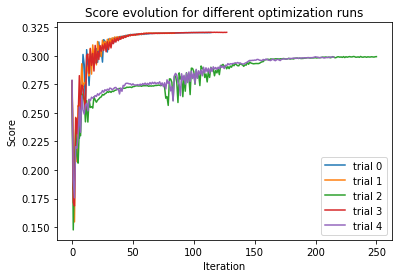

In [23]:
converged_scores = np.array([s[-1] for s in scores_all_trials])
q3 = np.percentile(converged_scores, 55)
q1 = np.percentile(converged_scores, 45)
iqr = q3 - q1
inlier_min = q1 - 1.5 * iqr
inlier_max = q3 + 1.5 * iqr
inliers = np.where((converged_scores > inlier_min) & (converged_scores < inlier_max))[0]
print 'inliers', inliers

plt.figure();
for trial_idx, scores in enumerate(scores_all_trials):
    plt.plot(scores, label='trial ' + str(trial_idx));
plt.xlabel('Iteration');
plt.ylabel('Score');
plt.legend();
plt.title('Score evolution for different optimization runs');

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
T_all_trials = np.array(T_all_trials)
t_std = np.std(pca.fit_transform(T_all_trials[inliers[:,None] ,[3,7,11]])[0])
t_std_um = t_std * XY_PIXEL_DISTANCE_TB
print 'Widest standard deviation of converged translation parameters for different trials: %.2f voxels, %.2f um' % (t_std, t_std_um)

# tx_std = np.std(T_all_trials[inliers, 3])
# ty_std = np.std(T_all_trials[inliers, 7])
# tz_std = np.std(T_all_trials[inliers, 11])
# tx_std_um = tx_std * XY_PIXEL_DISTANCE_TB
# ty_std_um = ty_std * XY_PIXEL_DISTANCE_TB
# tz_std_um = tz_std * XY_PIXEL_DISTANCE_TB
# print 'tx std:', tx_std, 'voxels', tx_std_um, 'um'
# print 'ty std:', ty_std, 'voxels', ty_std_um, 'um'
# print 'tz std:', tz_std, 'voxels', tz_std_um, 'um'

# plt.scatter(np.ones((5,)), np.array(T_all_trials)[:, 3], marker='+');
# plt.scatter(2*np.ones((5,)), np.array(T_all_trials)[:, 7], marker='+');
# plt.scatter(3*np.ones((5,)), np.array(T_all_trials)[:, 11], marker='+');

Best trial: 0
0.216239912435 0.212869237177
[[  9.65987135e-01   3.16554500e-01  -6.03069118e-02   6.42273031e+01]
 [ -2.93737823e-01   1.24593970e+00   5.03416836e-02   2.76519300e+01]
 [  4.25866995e-02  -2.44821545e-02   9.89498733e-01   2.51146958e+00]]


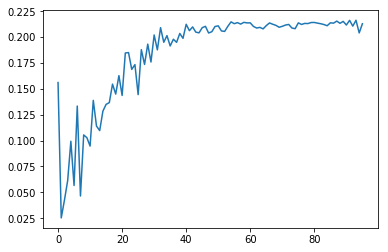

In [73]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [22]:
# print T.reshape((3,4))
# plt.plot(scores);
# print max(scores), scores[-1]

# Export parameters and score plots

In [84]:
for trial_idx in range(trial_num):
    
    T = T_all_trials[trial_idx]
    scores = scores_all_trials[trial_idx]
    
    params_fp = \
    DataManager.get_alignment_parameters_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  detector_id_f=detector_id,
                                                  warp_setting=warp_setting,
                                                  trial_idx=trial_idx)
    DataManager.save_alignment_parameters(params_fp, T, 
                                          aligner.centroid_m, aligner.centroid_f,
                                          aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                          aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
    upload_from_ec2_to_s3(params_fp)
    
    history_fp = DataManager.get_score_history_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                          classifier_setting_m=classifier_setting,
                                                          classifier_setting_f=classifier_setting,
                                                          warp_setting=warp_setting,
                                                          trial_idx=trial_idx)
    bp.pack_ndarray_file(np.array(scores), history_fp)
    upload_from_ec2_to_s3(history_fp)

    score_plot_fp = \
    DataManager.get_alignment_score_plot_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                         classifier_setting_m=classifier_setting,
                                                         classifier_setting_f=classifier_setting,
                                                         warp_setting=warp_setting,
                                                         trial_idx=trial_idx)
    fig = plt.figure();
    plt.plot(scores);
    plt.savefig(score_plot_fp, bbox_inches='tight')
    plt.close(fig)

    upload_from_ec2_to_s3(score_plot_fp)

aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_parameters.txt s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_parameters.txt


Child returned 0
0.81 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_scoreHistory.bp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_scoreHistory.bp


Child returned 0
0.70 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_scoreEvolution.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0/atlasV3_down32_scoreVolume_clf_30_warp_1_MD657_down32_scoreVolume_clf_30_trial_0_scoreEvolution.png


Child returned 0
0.81 seconds.


# Draw Results

In [74]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (affine_components_to_vector(-9.77304587,  48.73149657,  -2.80149108,  -0.16628751), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# ([1,0,0,0,0,1,0,0,0,0,1,0], 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [93]:
# Transform moving volume, sided, without surround

structure = 'IC'

vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

volume_m_alignedTo_f = \
transform_volume(vol=vol_m, global_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f,
                  xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)

In [94]:
# Set colors for different contour level
levels = [0.1, 0.25, 0.5, 0.75, .99]
level_colors = {level: (int(level*255),0,0) for level in levels}

In [ ]:
# Generate overlay visualization

# For getting correct contour location

xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = \
DataManager.load_original_volume_bbox(stack=stack_fixed, volume_type='score', structure='7N', 
                             downscale=32, detector_id=detector_id, prep_id=2)
print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

# Generate atlas overlay image for every section

zf, zl = bbox_3d(volume_m_alignedTo_f)[4:]
sec_first = DataManager.convert_z_to_section(stack=stack_fixed, z=zf, downsample=32)
sec_last = DataManager.convert_z_to_section(stack=stack_fixed, z=zl, downsample=32)

for sec in range(sec_first, sec_last+1, 5):
# for sec in [155]:
    
    if is_invalid(metadata_cache['sections_to_filenames'][stack_fixed][sec]):
        continue
    
    try:
#         img = DataManager.load_image(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
        sc_viz_fp = DataManager.get_scoremap_viz_filepath(stack=stack_fixed, section=sec, 
                                                           downscale=8,
                                                           structure=convert_to_original_name(structure), 
                                                           detector_id=detector_id, prep_id=2)
        download_from_s3(sc_viz_fp)
        img = imread(sc_viz_fp)[::4, ::4]
#         sc_viz_fp = DataManager.get_scoremap_viz_filepath(stack=stack_fixed, section=sec, 
#                                                            downscale=32,
#                                                            structure=convert_to_original_name(structure), 
#                                                            detector_id=detector_id, prep_id=2)
#         download_from_s3(sc_viz_fp)
#         img = imread(sc_viz_fp)
    except:
        sys.stderr.write('Error loading scoremap for section %d\n' % sec)
        continue
    
    viz = img.copy()
    
    z1, z2 = DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=32)
    z = int(z1)
    
    # Find moving volume annotation contours
    c = 0
    vol = volume_m_alignedTo_f
    for level in levels:
        cnts = find_contours(vol[..., z], level=level) # rows, cols
        c += len(cnts)
        for cnt in cnts:
            # r,c to x,y
            cnt_on_cropped = cnt[:, ::-1] + (xmin_vol_f, ymin_vol_f)
            cv2.polylines(viz, [cnt_on_cropped.astype(np.int)], True, level_colors[level], 1)
    
    if c > 0:    
        plt.figure(figsize=(20,20));
#         plt.figure();
        plt.title("sec=%d, z=%d, c=%d" % (sec, z, c));
        plt.imshow(viz);
        plt.show();
